<a href="https://colab.research.google.com/github/johnsonflygroup/SAMBA/blob/main/SAMBA_SAM2_Behavioural_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[IMAGE GO HERE :) ]

# SAMBA: **SAM**2 **B**ehavioural **A**nalysis

Use this notebook to run SAMBA on your video recordings. No coding knowledge necessary!

The instructions will guide you in connecting this notebook to a personal Google Drive account where you can upload your videos, and where SAMBA will store the results.

To use SAMBA, create a copy of this notebook in File > Save as copy in Drive.

Every time you start a new session (connect to a GPU) in the Google Colaboratory environment, you have to run all steps starting from Step 1. If the session has not disconnected, feel free to continue from the Analysis Option A or B sections after each run.

**Steps**

Run the following steps in order:

SAMBA features single video analysis or batch processing - Proceed with either Analysis Option A or B.

* [First: Instructions for selecting a GPU](#step-0)
* [Step 1: Set-up environment](#step-1)
* [Step 2: Set-up working directory](#step-2)
* [Step 3: Calibration](#step-3)
* [Analysis Option A - Single video](#analysis-a)
* [Analysis Option B - Batch processing](#analysis-b)

To run the code in a cell, either click inside it and press Ctrl + Enter, or hover your mouse over the [ ] icon and press play.

Step 1 can be run in its entirety by collapsing all the sections. Click the little arrow so it looks like '>' and then run all the code blocks in Step 1:

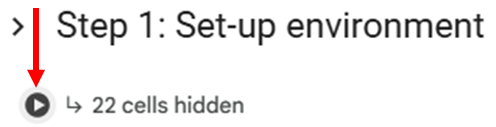

<a name="step-0"></a>

## First: Selecting a GPU


Follow the steps to select a GPU. **L4 GPU** (cost effective) or **A100** (fastest) are recommended.

Approximate processing times for a 3-minute video:

A100 GPU - 20 minutes

L4 GPU - 30 minutes

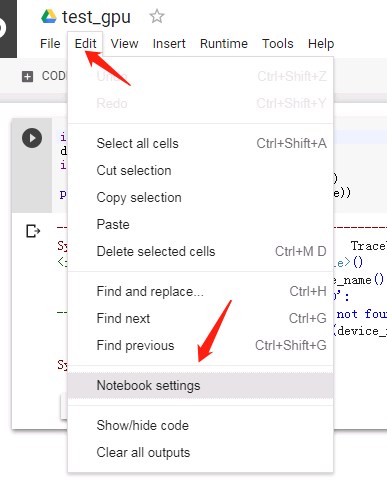

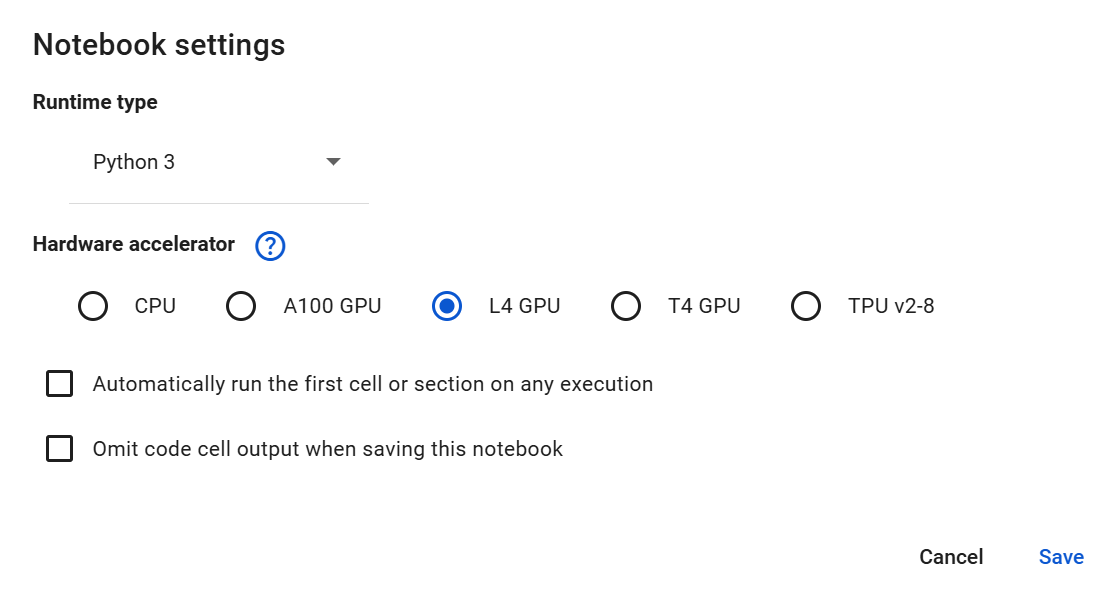

<a name="step-1"></a>

## Step 1: Set-up environment

Here we ensure the appropriate environment is set up for SAMBA to run, and define some helper functions that will be utilised in this notebook.

### 1.1 Install Python libraries and download SAM2 model

The code cells below will install the necessary Python libraries to ensure SAMBA can run, and download the model weights that SAM2 requires.

In [ ]:
# Install Python libraries
!pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
!pip install -q opencv-python==4.11.0.86 ultralytics==8.3.38 ffmpeg-python==0.2.0 ipympl==0.9.7 matplotlib==3.10.0 shapely==2.0.6

# Make code needed to run SAM2 accessible
!pip install -q 'git+https://github.com/Mward94/sam2-larvae.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 130.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Download SAM2 model weights
!wget -q -P ./sam2_checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

### 1.2 Import essential modules

Once the libraries have been installed, we need to import them to make them usable within the notebook.

There is currently a small bug in Google Colab that makes the interactive interface (when clicking on objects in a frame) not work. As such, we have code that will first automatically restart the notebook session and correct this error. You can safely ignore the warnings that are produced when the notebook automatically restarts.

The third code cell below will ensure that GPU acceleration is enabled (This is required to run SAMBA).

In [ ]:
# Restart session to enable clicking on objects
# Related Colab issue: https://github.com/googlecolab/colabtools/issues/5425
get_ipython().kernel.do_shutdown(restart=True);

In [ ]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from sam2.build_sam import build_sam2_video_predictor
from sam2.utils.utils import (
    get_video_info, extract_frames_ffmpeg, get_video_segments,
    get_frame_data_subset, add_raw_data, process_raw_data, get_aggregated_data,
    write_raw_data, write_aggregated_data, draw_track, draw_on_video)

# Enable clicking objects in a frame
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

In [ ]:
# Ensure a GPU is available and set up GPU configuration options
if not torch.cuda.is_available():
    raise RuntimeError(
        '[WARNING] No GPU was detected. A GPU is required to run SAMBA.\n' \
        'If using Google Colab, follow the steps outlined in the "Selecting a GPU" section.')
device = torch.device('cuda')

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### 1.3 Set-up helper functions

Here we define a series of helper functions that SAMBA needs to process video data. Once defined, these are reused later in the notebook.

In [ ]:
def track(
        video_path, frame_index, h, w, clicked_points,
        sam2_checkpoint="sam2_checkpoints/sam2_hiera_large.pt",
        model_cfg="sam2_hiera_l.yaml",
):
    """Performs object tracking on a video.
    """
    # Extract the video file name without extension
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    frames_dir = f'temp/{file_name}'

    # Extract individual frames from the video
    extract_frames_ffmpeg(video_path, frames_dir)

    # Initialise the SAM2 model for predicting
    predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)
    inference_state = predictor.init_state(video_path=frames_dir, offload_video_to_cpu=True, offload_state_to_cpu=True, async_loading_frames=True)

    prompts = {}                    # Hold all the clicks we add for visualisation
    ann_frame_idx = frame_index     # The frame index we interact with

    # Initialise the state with clicked points
    ann_obj_ids = list(range(len(clicked_points)))
    for clicked_point, ann_obj_id in zip(clicked_points, ann_obj_ids):
        points = np.array([clicked_point], dtype=np.float32)
        # for labels, `1` means positive click and `0` means negative click
        labels = np.array([1], np.int32)
        prompts[ann_obj_id] = points, labels
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

    # Run the model on the entire video
    video_segments = get_video_segments(predictor, inference_state, h, w)

    # Tidy-up to reduce memory constraints
    import gc
    del predictor, inference_state
    gc.collect()
    torch.cuda.empty_cache()

    # Delete extracted frames
    try:
        # Delete the folder and its contents
        shutil.rmtree(frames_dir)
        print(f"Folder '{frames_dir}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting folder: {e}")

    return video_segments

In [ ]:
def generate_output(
        video_segments, video_path, out_dir, fps, scale_factor, h, w,
        frame_count, csv_dir='csv', frame_csv_dir='raw_frames',
        paths_dir='paths', speeds_dir='speeds', sizes_dir='sizes',
        out_video_name='tracking.mp4', std_threshold=0.5,
):
    """
    """
    # Calculate per frame data
    frame_data = get_frame_data_subset(video_segments, step=1)
    frame_data = add_raw_data(frame_data, fps=fps, scale_factor=scale_factor, std_threshold=std_threshold)

    good_data, bad_data = process_raw_data(frame_data, speed_outlier_std=OUTLIER_MEAN_SPEED_STD, size_outlier_std=OUTLIER_MEAN_SIZE_STD)

    # Calculate aggregated per frame data
    aggregated_frame_data = get_aggregated_data(good_data, bad_data, fps=fps, scale_factor=scale_factor)

    # Save data to csv files
    write_raw_data(out_dir, frame_csv_dir, frame_data, index_label='frame')
    write_raw_data(out_dir, 'good_frames', good_data, index_label='frame')
    write_raw_data(out_dir, 'problematic_frames', bad_data, index_label='frame')
    write_aggregated_data(out_dir, aggregated_frame_data, fname='output.csv')

    # Draw tracks
    draw_track(out_dir, paths_dir, video_segments, h, w)

    # Draw on video
    draw_on_video(video_path, out_dir, out_video_name, video_segments, fps, h, w)

In [ ]:
def manual_pipeline(
        video_path, scale_factor, clicked_points, frame_index=0,
        base_out_dir='out', out_video_name='tracking.mp4', std_threshold=0.5,
):
    # prep
    file_name = os.path.splitext(os.path.basename(video_path))[0]

    out_dir = os.path.join(base_out_dir, file_name)

    if os.path.exists(out_dir):
        print(f'{out_dir} exists')
        return
    os.makedirs(out_dir, exist_ok=True)

    w, h, fps, frame_count = get_video_info(video_path)

    # tracking
    video_segments = track(video_path, frame_index, h, w, clicked_points=clicked_points)

    # generate output
    generate_output(video_segments, video_path, out_dir, fps, scale_factor, h, w, frame_count, out_video_name=out_video_name, std_threshold=std_threshold)

In [ ]:
def manual_pipeline_for_directory(
        directory_path, scale_factor, clicked_points_for_videos,
        base_out_dir='out', yolo_weights_path="yolov8_checkpoints/best.pt",
        error_log_path="error_log.txt", std_threshold=0.5,
):
    # Create the output directory if it doesn't exist
    os.makedirs(base_out_dir, exist_ok=True)

    # Open the error log file in write mode to log exceptions
    with open(error_log_path, "w") as error_log:
        # Use tqdm to add a progress bar
        for filename, values in clicked_points_for_videos.items():
            frame_index = values['frame_index']
            clicked_points = values['clicked_points']

            print(f"Processing {filename}")
            video_path = os.path.join(directory_path, filename)

            try:
                # Process each video using existing function
                manual_pipeline(video_path, scale_factor=scale_factor, clicked_points=clicked_points, frame_index=frame_index, base_out_dir=base_out_dir, out_video_name='tracking.mp4', std_threshold=std_threshold)
            except Exception as e:
                # Log the filename and the exception
                error_log.write(f"{filename} failed. Exception: {str(e)}\n")
                print(f"{filename} failed. Exception: {str(e)}\n")


In [ ]:
# Set-up calibration
def on_click1(event):
    """Function to capture click events"""
    if event.inaxes is not None:
        # Store the clicked coordinates
        clicks.append((event.xdata, event.ydata))

        # Mark the point on the image
        plt.plot(event.xdata, event.ydata, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        # Once we have two clicks, calculate the scale factor
        if len(clicks) == 2:
            # Disconnect the click event
            plt.gcf().canvas.mpl_disconnect(cid)

            # Calculate the scale factor
            global pixel_distance
            pixel_distance = get_pixel_distance(clicks[0], clicks[1])
            plt.close()  # Close the plot after the second click

def get_pixel_distance(point1, point2):
    """Calculate the scale factor based on two points"""
    # Calculate pixel distance between the two points
    pixel_distance = ((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)**0.5
    print(f"Pixel distance: {pixel_distance}")
    return pixel_distance

def calibrate(calibration_video_path):
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    ret, im0 = cap.read()

    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))

    ax.set_title('Click 2 points to calibrate scale factor')

    ax.imshow(im0)

    # Connect the click event handler to the plot
    global cid
    cid = fig.canvas.mpl_connect('button_press_event', on_click1)

    # Show the plot and wait for two clicks
    plt.show()

    cap.release()

In [ ]:
# Set-up manual pipeline

# Function to handle mouse click events
def onclick2(event):
    # Get the x and y coordinates
    x, y = event.xdata, event.ydata

    # Store the coordinates
    if x is not None and y is not None:
        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        clicked_points.append([x, y])

        # Mark the point on the image
        plt.plot(x, y, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

def show_frame(calibration_video_path, frame_index):
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read frame at specified position
    ret, im0 = cap.read()

    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(im0)
    ax.set_title(f'Frame {frame_index}. Click on the larvae to track')

    # Connect the click event to the onclick function
    cid = fig.canvas.mpl_connect('button_press_event', onclick2)

    # Display the image and wait for clicks
    plt.show()

    cap.release()


### 1.3 Outlier detection

Set your own outlier limits. Determines the cut-off for problematic frame flags. Currently optimised for Drosophila L3 larvae.

In [ ]:
# Constants for flagging problematic frames
# Specified as a number of standard deviations from the mean
# Frames flagged as problematic if +- N STDs from the mean
# Computed as: abs((val - mean) / std_dev)) > std_threshold
OUTLIER_MEAN_SPEED_STD = 5
OUTLIER_MEAN_SIZE_STD = 4

<a name="step-2"></a>

## Step 2: Set-up working directory

### 2.1 Connect Google Drive

Running the next cell will link SAMBA to Google Drive, accept permisions when asked.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Set main directory

Create a project directory in Google Drive and then provide the path:

For example, my project folder on Google Drive is **MyDrive/2024/larvatracking**. Don't modify the */content/drive/* part of the path.

In [ ]:
MAIN_DIR = '/content/drive/MyDrive/2024/larvatracking'

<a name="step-3"></a>

## 3 Calibration

### 3.1 Set scale factor if known

If the scale factor (mm/pixel) is known, you can set it here and move to the analysis.

Otherwise, set it to 0 to continue with the calibration process.

In [ ]:
#Enter scale factor if known, type '0' if unknown
scale_factor = 0


print(f"Scale factor: {scale_factor} mm/pixel")
if scale_factor == 0:
    print(f"Please procedd to the calibration steps")

Scale factor: 0.09 mm/pixel


### 3.2 Calibrating: Scale factor unknown

**Select calibration video**

Set the path of the video you want to use to calibrate (find mm/pixel).
The directory is in relation to the main directory set in 2.2




In [ ]:
calibration_video_path = f'{MAIN_DIR}/data/video/sarah/test/HetB2.mp4'

The first frame of the video will be shown. Click on 2 points where you know the physical measurement, i.e. a ruler in the frame or the arena diameter.

In [ ]:
# Variables to store the clicked points
clicks = []
pixel_distance = None

if not scale_factor:
    scale_factor = calibrate(calibration_video_path)

Run this cell, then when prompted, enter the known distance in mm.

In [ ]:
if not scale_factor:
    # get real-world distance between the two points
    real_world_distance = float(input('Enter real-world distance, in millimeters: '))  # Adjust as needed

    # Calculate the scale factor (real-world units per pixel)
    scale_factor = real_world_distance / pixel_distance
    print(f"Scale factor: {scale_factor} mm/pixel")

Enter real-world distance, in millimeters: 60


<a name="analysis-a"></a>

## Analysis Option A - Single video

### 1. Select a video

Set the video path to your video file.

In [ ]:
video_path = f'{MAIN_DIR}/data/video/sarah/test/HetA1.mp4'
frame_index = 0

### 2. Select objects to track

Click on the objects you would like to track.

If objects are overlapping in the first frame, in the previous code block, change frame_index = to any subsequent frame and re-run these blocks.

In [ ]:
# A list to store coordinates of clicked points
clicked_points = []

show_frame(video_path, frame_index)

### 3. Configurations

Set the video path to track and the output directory to store the results.

In [ ]:
video_path = f'{MAIN_DIR}/data/video/sarah/test/HetA1.mp4'
base_out_dir = f'{MAIN_DIR}/out/sarah/test'
std_threshold = 0.8  # the threshold at which SAMBA considers a Drosophila L3 larva to be in a bent state. See publication for details. Can be modified.

### 4. Tracking

In [ ]:
manual_pipeline(video_path, scale_factor, clicked_points, frame_index=frame_index, base_out_dir=base_out_dir, std_threshold=std_threshold)

<a name="analysis-b"></a>

## Analysis Option B - Batch processing

### 1. Set directory of videos


In [ ]:
directory_path = f'{MAIN_DIR}/data/video/sarah/hibhet'

### 2. Select objects to track

Initialize clicked objects list

In [ ]:
clicked_points_for_videos = {}

List all the video files inside the directory

In [ ]:
# Get list of files in the directory that match video extensions
video_fnames = [f for f in os.listdir(directory_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
video_fnames.sort()
for name in video_fnames: #just so you know I put this for loop in all by myself because I wanted to display the names in a vertical list (wow)
    print(name)

Change video_name inside the ' ' quotation marks to the name of the first video (make sure to include the file type e.g. .mp4)

Then, click on each object you want to track.


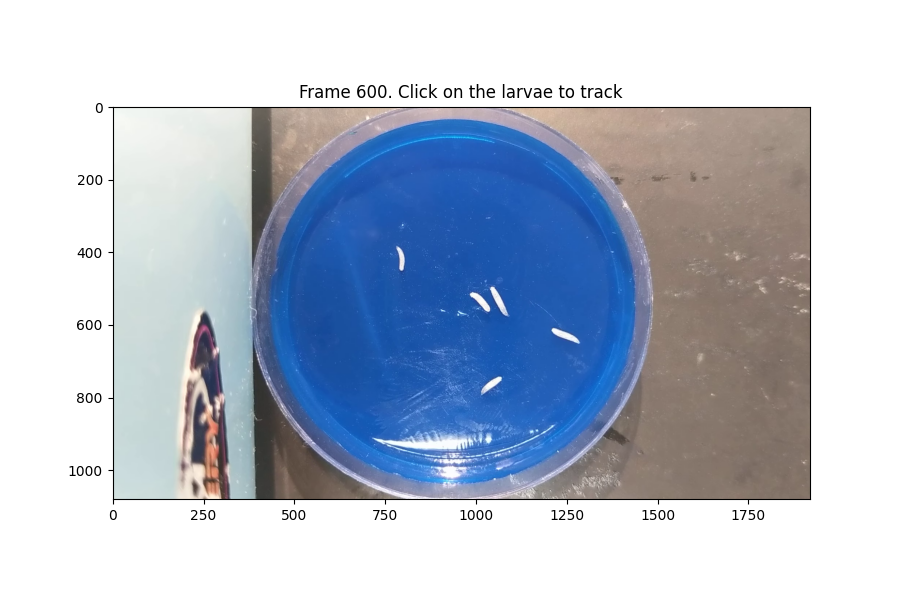

Clicked at: (796.4032258064515, 407.3709677419356)
Clicked at: (1016.6182795698924, 533.994623655914)
Clicked at: (1066.1666666666665, 533.994623655914)
Clicked at: (1250.5967741935483, 633.0913978494624)
Clicked at: (1049.6505376344087, 754.2096774193549)


In [ ]:
video_name = 'Video.mp4'
frame_index = 0

video_path = os.path.join(directory_path, video_name)

# A list to store coordinates of clicked points
clicked_points = []

show_frame(video_path, frame_index)

Save the clicked points for this video, then go back up to video_name

Repeat this process for all videos in the directory.

In [ ]:
clicked_points_for_videos[video_name] = {
    'frame_index': frame_index,
    'clicked_points': clicked_points.copy(),
}

(Optional): View the saved clicked points

If you make a mistake for a video, repeat the process for that video, the new clicked points will override the old ones.

In [ ]:
clicked_points_for_videos

When you are happy with the clicked points, move on to the next section

### 3. Configurations


Set the directory folder and the output folder

In [ ]:
directory_path = f'{MAIN_DIR}/data/video/sarah/hibhet'
base_out_dir = f'{MAIN_DIR}/out/sarah'
std_threshold = 0.8  # # the threshold at which SAMBA considers a Drosophila L3 larva to be in a bent state. See publication for details. Can be modified.

### 4. Tracking

SAMBA will sequentially track each video in the batch automatically

In [ ]:
manual_pipeline_for_directory(directory_path, scale_factor, clicked_points_for_videos, base_out_dir=base_out_dir, yolo_weights_path='yolov8_checkpoints/best.pt', error_log_path=os.path.join(base_out_dir, "error_log.txt"), std_threshold=std_threshold)